##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [79]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [80]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

# from new.ipynb

In [81]:
###...code...###
df = pd.read_parquet(filepath)
print(df.shape)
df.head().style

(17992, 304)


,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_

*Clean the data*

In [82]:
df['race_desc'].unique()

array(['Chinese', 'Others', 'Indian', None, 'Malay'], dtype=object)

In [83]:
df['ctrycode_desc'].unique()

array(['Singapore', 'Not Applicable', 'Malaysia', 'United Kingdom',
       'Brunei Darussalam', 'Hong Kong', 'Indonesia', 'Philippines',
       'Thailand', 'Australia', None, 'United Arab Emirates', 'Japan',
       'Spain', 'China', 'Taiwan (R.O.C)', 'United States', 'Denmark',
       'Unknown Country Code', 'South Africa', 'Sweden', 'Ireland',
       'New Zealand', 'Netherlands', 'Italy', 'Bosnia-Herzegovina',
       'Canada'], dtype=object)

In [84]:
def clean_general_info(df):
    df1 = df.copy()

    # drop clntnum
    df1 = df1.drop("clntnum", axis=1)
    
    #fill na for race_desc and ctrycode_desc
    df1['race_desc'] = df1['race_desc'].fillna("Others")
    df1['ctrycode_desc'] = df1['ctrycode_desc'].fillna("Not Applicable")

    # clttype: personal, group and corporate
    # flag: encoding

    # convert to datetime 
    # check nan value, should we fill it with today?
    df1['min_occ_date'] = pd.to_datetime(df1['min_occ_date'], errors='coerce')
    years_with_singlife = (pd.to_datetime('now') - df1['min_occ_date']).dt.days / 365.25
    mean_duration = years_with_singlife.median() # pick median instead of mean ???
    df1['years_with_company'] = years_with_singlife.fillna(mean_duration).astype(int)
    df1.drop('min_occ_date', axis=1, inplace=True) # drop??

    # cltdob_fix: calculate age
    df1['cltdob_fix'] = pd.to_datetime(df1['cltdob_fix'], errors='coerce')
    age_in_years = (pd.to_datetime('now') - df1['cltdob_fix']).dt.days / 365.25
    mean_age = age_in_years.mean()
    df1['age'] = age_in_years.fillna(mean_age).astype(int) # fill with mean age
    # dropping DOB column 
    df1.drop('cltdob_fix', axis=1, inplace=True)

    # None value in gender 
    df1['cltsex_fix'].unique()
    # method 1: if None then male, method2: dropna, here I used method 1
    df1['cltsex_fix'] = df1['cltsex_fix'].fillna('Male')

    return df1 
df1 = clean_general_info(df)

In [85]:
df1['num_total_claims'] = (df1['flg_has_health_claim'] + df1['flg_has_life_claim'] + df1['flg_gi_claim']).fillna(0)

In [86]:
import numpy as np
# 3. combine risk together: substandard risk -> level 3, boarderline -> level 2, standard -> level 1 
conditions = [
    df1['flg_substandard'] == 1,
    df1['flg_is_borderline_standard'] == 1,
    ~(df1['flg_substandard'] == 1) & ~(df1['flg_is_borderline_standard'] == 1)  # Standard risk
]

values = [3, 2, 1]

# Create a new column 'risk_level' based on the conditions, if na means standard 
df1['risk_level'] = np.select(conditions, values, default=1)

df1.drop(columns = ['flg_substandard','flg_is_borderline_standard','flg_has_health_claim','flg_has_life_claim','flg_gi_claim'],inplace=True)


In [87]:
col = df1.iloc[:,18:22].columns
for column in col:
    df1[column] = df1[column].fillna(0).astype(float).astype(int)

In [88]:
df1['annual_income_est'] = df1['annual_income_est'].fillna("F.UNKNOWN")
income_mapping = {
    'F. OTHERS': 1,
    'E.BELOW30K': 2,
    'D.30K-60K': 3,
    'C.60K-100K': 4,
    'B.100K-200K': 5,
    'A.ABOVE200K': 6
}

# Apply ordinal encoding
df1['annual_income_encoded'] = df1['annual_income_est'].map(income_mapping)

In [89]:
df1['hh_size_est'] = df1['hh_size_est'].fillna("0")
hh_size_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '>4': 5,
    '0': 0
}

# Apply ordinal encoding
df1['hh_size_est_encoded'] = df1['hh_size_est'].map(hh_size_mapping)

df1.drop(columns=['hh_20','pop_20','hh_size','hh_size_est','annual_income_est'],inplace=True)

In [90]:
consent_col = df1.iloc[:,12:18].columns 
for column in consent_col:
    df1[column] = df1[column].fillna(0).astype(float).astype(int) # na can just assume they don't consent 

conditions = [
    (df1['is_consent_to_call'] == 1),
    (df1['is_consent_to_email'] == 1) & (df1['is_valid_email'] == 1),
    (df1['is_consent_to_mail'] == 1) & (df1['is_valid_dm'] == 1),
    (df1['is_consent_to_sms'] == 1)
]

values = [5, 1, 1, 1]

# Create the 'consent_level' column by summing the values based on the conditions
df1['consent_level'] = np.sum(np.column_stack(conditions) * np.array(values), axis=1)

# Visualization 
## Age distribution

/var/folders/ls/8gbvtyrd07g59v3ct9lcsmm00000gn/T/ipykernel_55682/3508266545.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['age'],bins=20)


<Axes: xlabel='age', ylabel='Density'>

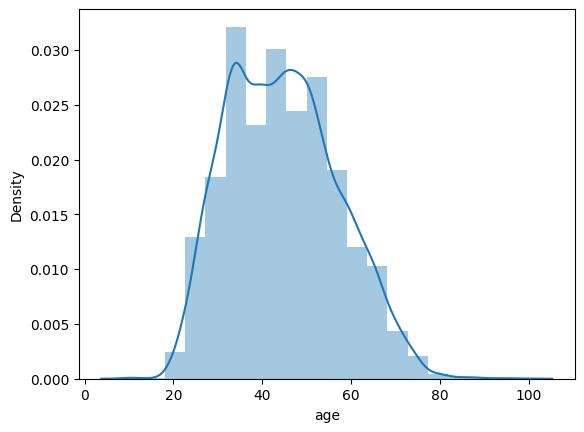

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(df1['age'],bins=20)

# Liveness
## Figures to consider 
- Times of purcharing the products 
- consent score (from the consent level, call: 5, others: 1)
- n_months_last_bought_products	(if not buy, set a big num)
- recency_lapse (negative impact)
- recency_cancel (negative impact)
- avg_purchase_frequency
- avg_cancel_rate


Liveness Score=(0.3×Times of purchasing products)+(0.3×Consent level)−(0.1×Number of months since last purchase)−(0.2×Recency lapse)−(0.2×Recency cancel)+(0.3×Average purchase frequency)−(0.2×Average cancel rate)

## Consent score 

In [92]:

df = df1
df['consent_score'] = 0  
# call : 5 others: 1
df.loc[df['is_consent_to_call'] == 1, 'consent_score'] += 5
df.loc[df['is_consent_to_mail'] == 1, 'consent_score'] += 1
df.loc[df['is_consent_to_email'] == 1, 'consent_score'] += 1
df.loc[df['is_consent_to_sms'] == 1, 'consent_score'] += 1
df.loc[df['is_valid_dm'] == 1, 'consent_score'] += 1
df.loc[df['is_valid_email'] == 1, 'consent_score'] += 1

df['total_score'] = df['consent_score']

In [93]:
df['total_score'].unique()

array([ 2,  1,  4,  5, 10,  8,  0,  9,  3,  6,  7])

## n_months_last_bought_products
- all negative numbers set to 0 (assume negative number is wrong/pre paid, cuz this figure is now weighted -0.1, set to 0 to show they just buy. Also, only 8 rows with this fig < 0, almost no effect)
- no missing value.


In [94]:
df['n_months_last_bought_products'].dtype

dtype('int64')

In [95]:
df[df['n_months_last_bought_products'] < 0]

,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,...,f_purchase_lh,years_with_company,age,num_total_claims,risk_level,annual_income_encoded,hh_size_est_encoded,consent_level,consent_score,total_score
18769,Others,Singapore,P,ACTIVE,Male,0.0,0.0,0.0,0.0,0.0,...,1.0,6,43,1.0,1,3.0,3,3,5,5
3260,Others,Singapore,P,ACTIVE,Female,0.0,0.0,0.0,0.0,0.0,...,1.0,1,49,0.0,1,6.0,3,1,3,3
17875,Chinese,Singapore,P,ACTIVE,Male,0.0,0.0,0.0,0.0,0.0,...,NaN,17,45,0.0,2,4.0,1,2,4,4
4354,Chinese,Singapore,P,ACTIVE,Female,0.0,0.0,0.0,0.0,0.0,...,NaN,6,44,0.0,1,6.0,2,0,1,1
10379,Chinese,Singapore,P,ACTIVE,Male,0.0,0.0,0.0,0.0,0.0,...,1.0,31,59,1.0,1,2.0,2,1,3,3
2283,Chinese,Singapore,P,ACTIVE,Male,0.0,0.0,0.0,0.0,0.0,...,1.0,5,45,0.0,1,6.0,2,1,3,3
18333,Chinese,Singapore,P,ACTIVE,Male,0.0,0.0,0.0,0.0,0.0,...,1.0,4,41,0.0,1,6.0,1,1,3,3
19933,Chinese,Singapore,P,ACTIVE,Male,0.0,0.0,0.0,0.0,0.0,...,1.0,22,66,1.0,1,6.0,3,2,4,4


In [96]:
df.loc[df['n_months_last_bought_products'] < 0, 'n_months_last_bought_products'] = 0

In [97]:
df['n_months_last_bought_products'].max()

847

In [98]:
df['n_months_last_bought_products'].isnull().sum()

0

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [99]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [100]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!